In [1]:
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import floatpy.readers.padeops_reader as por
%matplotlib inline
%config InlineBackend.figure_format = 'png'
import scripts.get_namelist as nml

color1=[51./255, 105./255, 169./255]
color2=[200./255, 90./255, 90./255]
fs = 12
xdir = 0
ydir = 1
zdir = 2

def get_q(reader,qname):
    u = reader.readData(qname);
    u = np.squeeze(u);
    ubar = np.mean(np.mean(u,axis=1),axis=0);
    uprime2D = np.squeeze(u-ubar)
    return u,ubar,uprime2D

def get_qf(reader,qname):#Favre average
    r,u = reader.readData(('rho',qname));
    u = np.squeeze(u);
    r = np.squeeze(r);  
    rbar   = np.mean(np.mean(r))
    utilde = np.mean(np.mean(r*u))/rbar;
    upprime2D = np.squeeze(u-utilde)
    return u,utilde,upprime2D


directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr1/1024x1448x512/'

reader = por.PadeopsReader(directory+'/shearlayer_', periodic_dimensions=(True,False,True))
steps = sorted(reader.steps)
print("Steps:\t{}".format(steps))
readerTKE = por.PadeopsReader(directory+'TKEBudget_', periodic_dimensions=(True,False,True))
x, y, z = readerTKE.readCoordinates()
ymin, ymax = y[0,0,0], y[-1,-1,-1]
stepsTKE = sorted(readerTKE.steps)
print("TKE steps:\t{}".format(stepsTKE))

Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory)
kx = [2.0*np.pi/float(Lx)*w for w in range(0,int(Nx/2))]; kx = np.array(kx)
kz = [2.0*np.pi/float(Lz)*w for w in range(0,int(Nz/2))]; kz = np.array(kz)
dx = Lx/Nx
print(max(kx))
inp = nml.inputs(directory,verbose=1)
   
# 'rho_bar', 'tke', 'TKE_rate','dissipation', 'dissipation_num', 'p_dil_fluct', 'fluct_p_dil', 'production','baropycnal', 'u_tilde', 'u_pprime_bar'

Steps:	[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 581, 582]


ValueError: invalid literal for int() with base 10: '044_'

step	time	eta		eta/dx
0	87.150	0.02209		0.28274
1	87.300	0.02203		0.28196


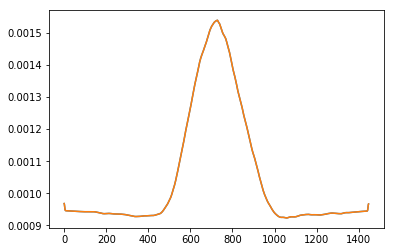

In [70]:
def get_eta(reader,readerTKE,yslice):
    
    diss,diss_num = readerTKE.readData(('dissipation','dissipation_num'))
    eps = np.squeeze(np.array(diss+diss_num))
    eps = eps[yslice]

    rho,mu = reader.readData(('rho','mu'))
    nu = mu/rho
    nu = np.mean(np.mean(nu,axis=zdir),axis=xdir)
    nu = np.squeeze(np.array(nu))
    yslice = np.argmax(nu)
    plt.plot(nu)
    nu = nu[yslice]
    
    eta = (nu**0.75)*(eps**-0.25)
    u_eta = (nu*eps)**0.25
    t_eta = (nu/eps)**0.5
    
    return readerTKE.time,nu,eps,eta,u_eta,t_eta

reader.step = 582#max(steps)-1

print("step\ttime\teta\t\teta/dx")
for step in stepsTKE[:2]:
    readerTKE.step = step
    t,nu,eps,eta,u_eta,t_eta = get_eta(reader,readerTKE,int(Ny/2))
    print("%i\t%0.3f\t%0.5f\t\t%0.5f"%(step,t,eta,eta/dx))
plt.show()


Time: 87.15
/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr1/1024x1448x512/restart_0044_nofilter/
0.8840697086860683


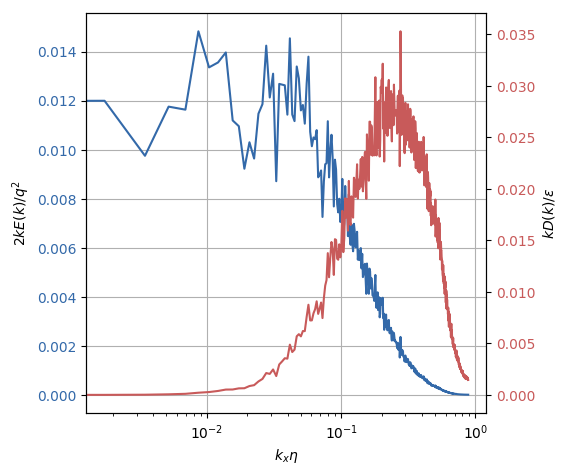

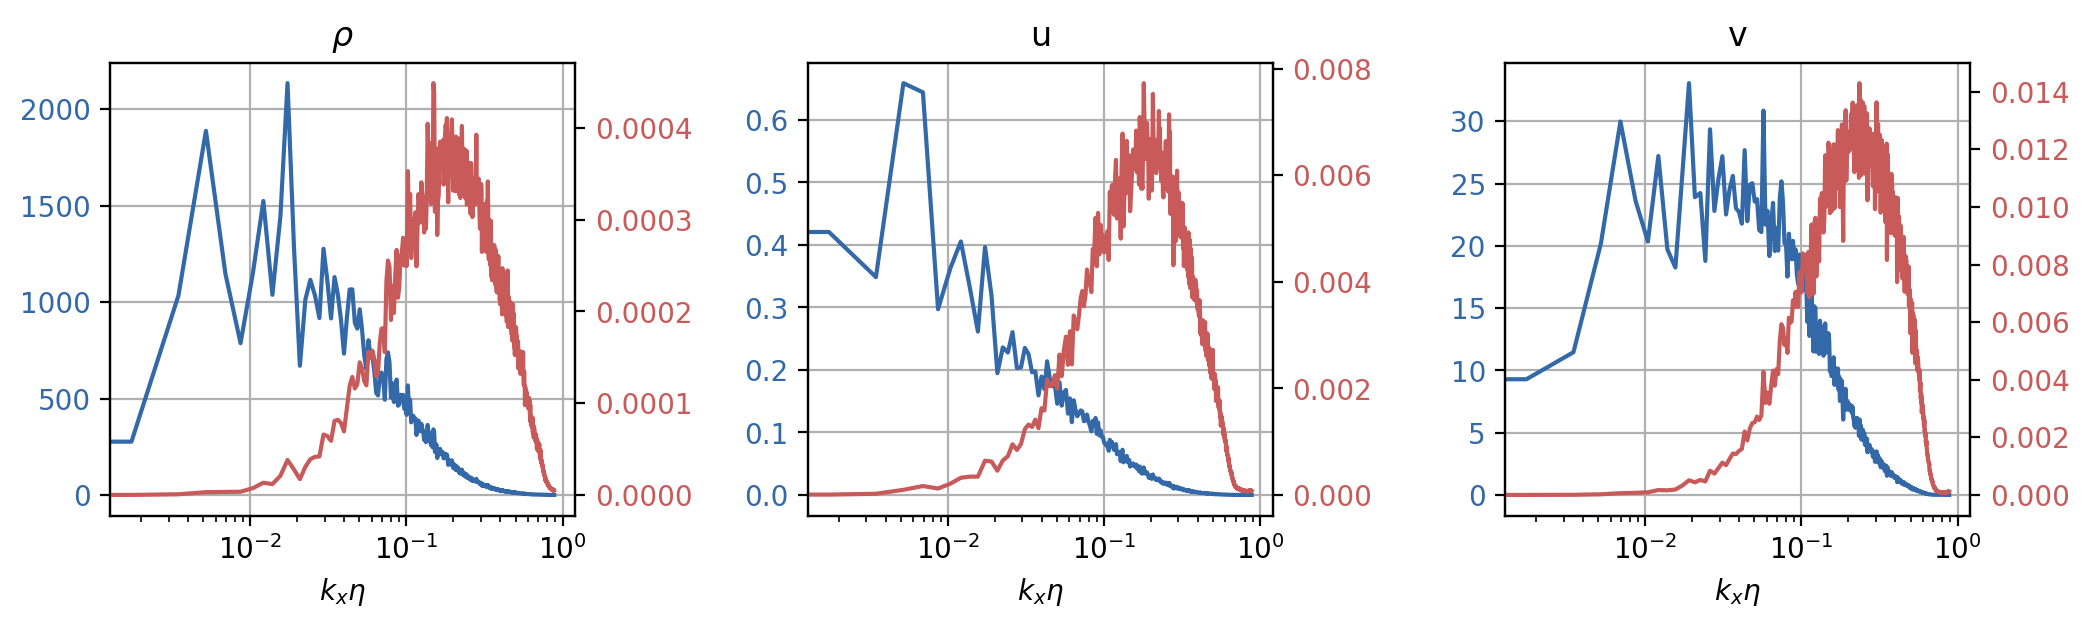

In [77]:
# Dissipation spectrum

def Eii(uprime,k_axis):
    uhat = 1./Nx * np.fft.fft(uprime,axis=k_axis)
    return 2.* np.mean( np.square(np.abs(uhat)),1)

def energy_spectra(reader,readerTKE,yslice,plotOpt=True):
    reader.sub_domain = (0,yslice,0), (reader.domain_size[0]-1, yslice, reader.domain_size[2]-1)    
    # Get kolmogorov scales
    # t,nu,eps,eta,u_eta,t_eta = get_eta(reader,readerTKE,int(Ny)/2)

    # Get tke
    r,R,rprime2D = get_qf(reader,'rho')
    u,U,uprime2D = get_qf(reader,'u')
    v,V,vprime2D = get_qf(reader,'v')
    w,W,wprime2D = get_qf(reader,'w')
    TKEspec = Eii(uprime2D**2+vprime2D**2+wprime2D**2,k_axis=0)
    
    idx = range(int(Nx)/2)
    E = TKEspec[idx]
    D = 2*nu*E*kx**2
    tmp[1] = E
    
    if plotOpt:
        fig = plt.figure(figsize=(4,4), dpi=100)
        ax = fig.add_axes([0,0,1,1])
        i=0
        plt.semilogx(kx*eta,2*kx*E/E[0]**2,color=color1)
        plt.xlabel(r'$k_x\eta$')
        plt.ylabel(r'$2kE(k)/q^2$')
        plt.tick_params(axis='y', labelcolor=color1)
        plt.grid(True)

        ax2 = ax.twinx()
        ax2.semilogx(kx*eta,kx*D/eps,color=color2)
        ax2.set_ylabel(r'$kD(k)/\epsilon$')
        ax2.tick_params(axis='y', labelcolor=color2)

        plt.subplots_adjust(wspace=0.5,hspace=0.1)

        fig, ax = plt.subplots(1,3, figsize=(12,3), dpi=200)
        i=0
        for i,qname in zip(range(3),['r','u','v']):
            if qname=='r': qprime = rprime2D; qname=r'$\rho$'
            elif qname=='u': qprime = uprime2D
            elif qname=='v': qprime = vprime2D
            Espec = Eii(qprime,k_axis=0)
            E = Espec[idx]
            D = 2*nu*E*kx**2

            ax[i].semilogx(kx*eta,2*kx*E/E[0]**2,color=color1)
            ax[i].set_xlabel(r'$k_x\eta$')
            ax[i].tick_params(axis='y', labelcolor=color1)
            ax[i].grid(True)
            ax[i].set_title(qname)

            ax2 = ax[i].twinx()
            ax2.semilogx(kx*eta,kx*D/eps,color=color2)
            #ax2.set_ylabel(r'$kD(k)/\epsilon$')
            ax2.tick_params(axis='y', labelcolor=color2)

        plt.subplots_adjust(wspace=0.5,hspace=0.1)

readerTKE.step = max(stepsTKE)
reader.step = 581#max(steps)
print("Time: {}".format(reader.time))

print(directory)
mat = energy_spectra(reader,readerTKE,int(Ny)/2)
print(max(kx*eta))

87.14999999999999


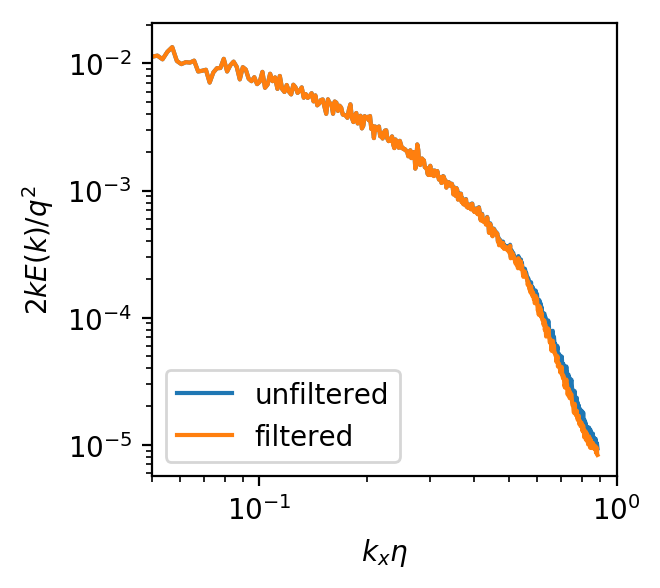

In [78]:
# tmp = {}
plt.figure(figsize=(3,3),dpi=(200))
plt.loglog(kx*eta,2*kx*tmp[1]/tmp[1][0],label='unfiltered') # filter
plt.loglog(kx*eta,2*kx*tmp[0]/tmp[0][0],label='filtered') #no filter
plt.ylabel(r'$2kE(k)/q^2$')
plt.xlabel(r'$k_x \eta$')

# plt.semilogx(kx*eta,kx*tmp[0]/eps,label='unfiltered') #no filter
# plt.semilogx(kx*eta,kx*tmp[1]/eps,label='filtered') # filter
# plt.ylabel(r'$kD(k)/\epsilon$')
# plt.xlabel(r'$k_x \eta$')
# plt.grid(True)

plt.xlim([5e-2,1])
plt.legend()
print(reader.time)